# Advanced processing

The aim of this notebook is to teach you how to use NexusFile in conjunction with h5py to create custom processes and save your results to the HDF5 file.

I heavily recommend you read the two other notebooks before going in this one.

In [1]:
# Imports

%matplotlib ipympl

import os
import h5py
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

from SWAXSanalysis.class_nexus_file import NexusFile
from SWAXSanalysis.utils import explore_file, save_data

  File "C:\Python310\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Python310\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\AT280565\Desktop\Data Treatment Center\Jupyter notebooks\.venv\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\AT280565\Desktop\Data Treatment Center\Jupyter notebooks\.venv\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\AT280565\Desktop\Data Treatment Center\Jupyter notebooks\.venv\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "C:\Users\AT280565\Desktop\Data Treatment Center\Jupyter notebooks\.venv\lib\site-packages\tornado\platform\asyncio.py", line 211, in start
    self.asyncio_loop.run_forever()
  File "C:\Python310\lib\asyncio\base_events.py", line 595, in run_forever
    self._run_once()
 

# Getting raw data

The first thing you need to know before creating your own process is how to extract data from the HDF5 file. To do this you can use the method `get_raw_data` from the NexusFile class.

The method returns two python dictionary :
1. The parameter dictionary :
    - Key : The name of the file
    - Value : The parameter (1D or 2D) from the DATA group you requested
2. The value dictionary :
    - Key : The name of the file
    - Value : The value (1D or 2D) from the DATA group you requested

In [2]:
# This is the path you want to change
data_dir = Path(r".\Example HDF5")

path_list = []

for file in data_dir.iterdir():
    if file.suffix == ".h5":
        path_list.append(file)
        print(file.name)

testSample_SAXS_00001.h5


In [3]:
nx_files = NexusFile(path_list, do_batch=True)
try:
    print("file opened!")
    dict_param, dict_value = nx_files.get_raw_data(group_name="DATA")
except Exception as error:
    print(error)
finally:
    nx_files.nexus_close() # Very important !
    print("file closed!")

print("dict_param type : ", type(dict_param))
print("dict_param type : ", type(dict_value))

file opened!
file closed!
dict_param type :  <class 'dict'>
dict_param type :  <class 'dict'>


## Checking if data has been correctly extracted

We can plot the data using matplotlib directly to check if it's what we're expecting

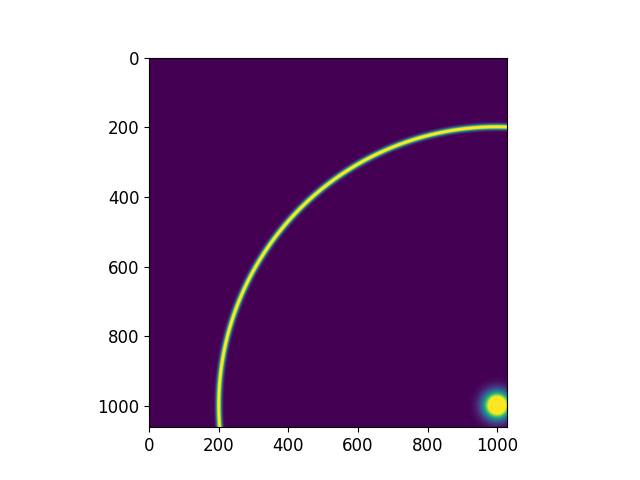

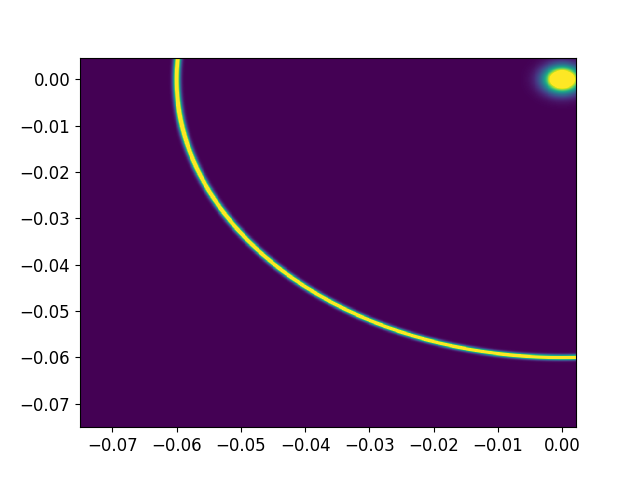

In [4]:
for key, data in dict_value.items():
    param = dict_param[key]
    plt.figure()
    plt.imshow(
        data,
        vmin=0,
        vmax=np.percentile(
            data[~np.isnan(data)],
            99)
    )
    plt.figure()
    plt.pcolormesh(
        param[0, ...],
        param[1, ...],
        data,
        vmin=0,
        vmax=np.percentile(
            data[~np.isnan(data)],
            99)
    )

## Actually doing the custom processing

Now that you got your data, you can do whatever you want with it. This example file is obviously not a real measure, it's been created by hand, let's make it a bit more belivable by adding a random background !

To do the processing I recommend you use a `for` loop that uses either `dict_param.keys()` or `dict_value.keys()`. The point is to get the key associated to the data, that way you can create a new dictionary with the same keys and the new data. This will help you save the data in the HDF5 file later.

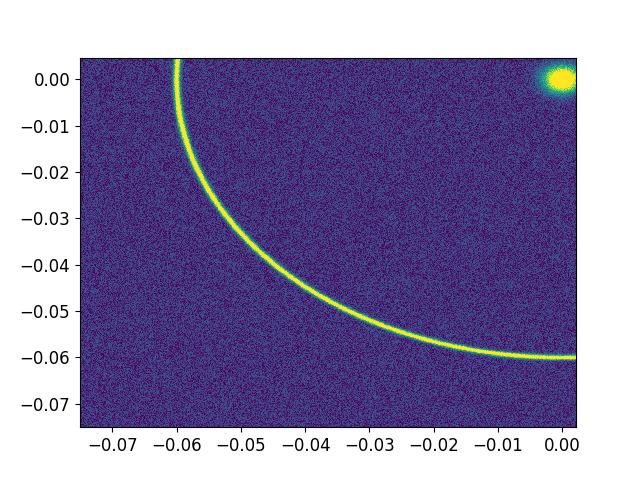

In [5]:
new_data_dict = {}
for key in dict_value.keys():
    param = dict_param[key]
    data = dict_value[key]
    
    # We create the random back ground 
    background = np.random.rand(*np.shape(data)) * 2
    new_data = data + background

    # We save the new data as a dictionnary with the same key but the new data instead
    new_data_dict[key] = new_data

    # Wep lot as we go through all the keys
    plt.figure()
    plt.pcolormesh(
        param[0, ...],
        param[1, ...],
        new_data,
        vmin=0,
        vmax=np.percentile(
            new_data[~np.isnan(new_data)],
            99)
    )

## Saving in the HDF5 file

To save data in the HDF5 file you can use the `save_data` function, present in the `SWAXSanalysis.utils` module. You could also save by using h5py, which is lower level and gives you more control, but it's not recommended since you might go against the NXcanSAS standard.

To save data you also go through a `for` loop but iterating over `new_data_dict.items()` this time, that way you get both keys and data at the same time. It is also recommended to do the processing and saving in one loop since it'll be faster but for the purpose of this tutorial and clarity I chose to do it in two loops.

Inside this `for` loop you can then use the `with h5py.File(path, "r+") as h5_object:` environment and `save_data` to save the new data inside the file you opened thanks to ` h5py.File(path, "r+")`. Note that we use "r+" to write and read the file at the same time.

We also display the old and new structure as an example.

In [6]:
for key, value in new_data_dict.items():
    path = data_dir / key
    print(path.absolute())
    with h5py.File(path, "r+") as h5_object:
        print("Structure before saving")
        explore_file(h5_object, explore_group=False, explore_attribute=False)
        
        save_data(
            nx_file=h5_object,
            new_group_name="DATA_REALISTIC",
            parameter_symbol="Q",
            parameter_data=dict_param[key],
            value_data=value,
            mask=[np.logical_not(value > -1)]
        )

        print("Structure after saving")
        explore_file(h5_object, explore_group=False, explore_attribute=False)

C:\Users\AT280565\Desktop\Data Treatment Center\Jupyter notebooks\NoteBook\Example HDF5\testSample_SAXS_00001.h5
Structure before saving
Exploring HDF5 structure...

├──Group : ENTRY
|  ├──Group : ENTRY/COLLECTION
|  ├──Group : ENTRY/DATA
|  ├──Group : ENTRY/DATA_ABS
|  ├──Group : ENTRY/DATA_AZI_AVG
|  ├──Group : ENTRY/DATA_CAKED
|  ├──Group : ENTRY/DATA_HOR_INT
|  ├──Group : ENTRY/DATA_Q_SPACE
|  ├──Group : ENTRY/DATA_RAD_AVG
|  ├──Group : ENTRY/DATA_VER_INT
|  ├──Group : ENTRY/INSTRUMENT
|  |  ├──Group : ENTRY/INSTRUMENT/APERTURE
|  |  ├──Group : ENTRY/INSTRUMENT/COLLIMATOR
|  |  ├──Group : ENTRY/INSTRUMENT/DETECTOR
|  |  ├──Group : ENTRY/INSTRUMENT/SOURCE
|  ├──Group : ENTRY/PROCESS
|  ├──Group : ENTRY/PROCESS_ABS
|  ├──Group : ENTRY/PROCESS_AZI_AVG
|  ├──Group : ENTRY/PROCESS_CAKED
|  ├──Group : ENTRY/PROCESS_HOR_INT
|  ├──Group : ENTRY/PROCESS_Q_SPACE
|  ├──Group : ENTRY/PROCESS_RAD_AVG
|  ├──Group : ENTRY/PROCESS_VER_INT
|  ├──Group : ENTRY/SAMPLE
Structure after saving
Exploring

The data has been properly saved inside the hdf5 file, although there is no process description. To do that you need to use `create_process` which is in the `SWAXSanalysis.nexus_file_class` module. This is optional but recommended to ensure reproductability.

Now that we have more belivable data, let's see what its 1D profile looks like by returning to the NexusFile class :

file opened!


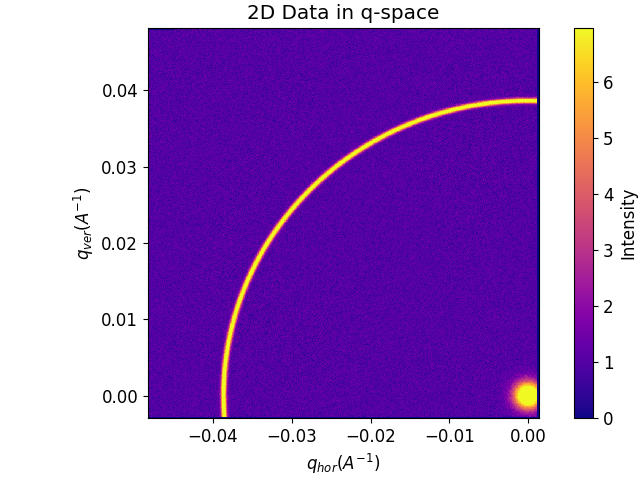

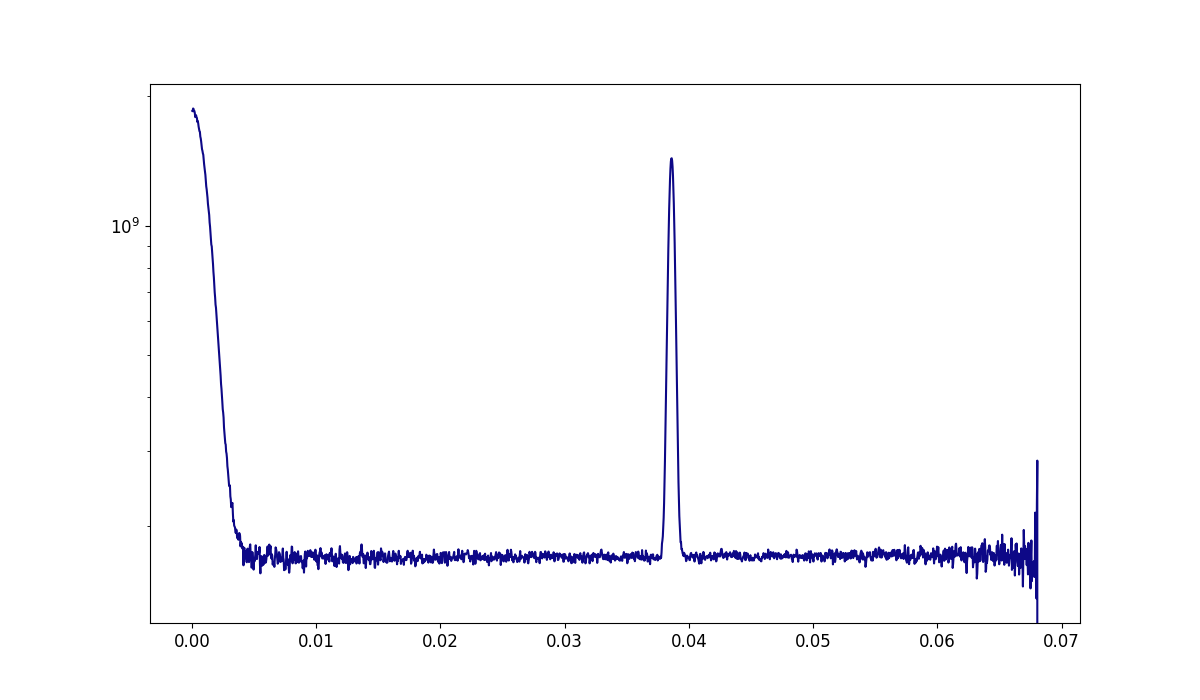

file closed!


In [7]:
nx_files = NexusFile(path_list, do_batch=True, input_data_group="DATA_REALISTIC")
try:
    print("file opened!")
    nx_files.process_q_space(
        display=True,
        save=True,
        group_name="DATA_REAL_Q_SPACE"
    )
    nx_files.process_radial_average(
        display=False,
        save=True,
        group_name="DATA_REAL_RAD_AVG"
    )
    nx_files.process_display(
        group_name="DATA_REAL_RAD_AVG",
        scale_x="linear"
    )
except Exception as error:
    print(error)
finally:
    nx_files.nexus_close() # Very important !
    print("file closed!")